# Fig. 4. Decomposition results at rank=3

In [1]:
import os
import glob
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import xarray as xr
import tsnmf

## Load low-rank MVBS data

In [2]:
MVBS_PCP_path = '../data/'
MVBS_rpca_file = '20150817-20151017_MVBS_time_Sv_rangeBin5_all_corrected_rpca.nc'

In [3]:
MVBS_rpca = xr.open_dataset(os.path.join(MVBS_PCP_path, MVBS_rpca_file))
low_rank = MVBS_rpca['low_rank']
n_observations, n_frequencies, n_depth_levels, n_pings = low_rank.shape

In [4]:
low_rank = low_rank.values.reshape([n_observations,-1])

In [5]:
low_rank_nonneg = low_rank - low_rank.min()
low_rank_nonneg.shape

(62, 15984)

## tsNMF decomposition

From previous analysis we selected the tsNMF run at rank=4 with `random_seed=960`. Here we use this initial condition to perform the decomposition again.

In [6]:
model = tsnmf.smoothNMF(n_components=3, 
                        max_iter=2000, 
                        smoothness=500000, 
                        sparsity=0, 
                        early_stopping={'type': 'cost'}
                       )
model.fit(low_rank_nonneg.T, init='random', random_state=1190)

Stopping at iteration 702


We normalize the $\mathbf{W}$ components by its norm and multiply the norm to the $\mathbf{H}$ activations.

In [7]:
H_multW = (model.H.T * np.linalg.norm(model.W, axis=0)).T
W_divW = model.W / np.linalg.norm(model.W, axis=0)

Set the plotting sequence of components so the results can be easily compared with rank=3 results.

In [8]:
comp_seq_idx = np.array([0,2,1])

## Fig. 4.

Reshape the normalized H and W for plotting:

In [9]:
H_multW.shape, W_divW.shape

((3, 62), (15984, 3))

In [10]:
Ws_reshaped = W_divW[:, comp_seq_idx].T.reshape(3, n_frequencies*n_depth_levels, n_pings)
Hs_reshaped = H_multW[comp_seq_idx, :].T

In [11]:
import datetime

In [12]:
# Assemble dataset for activation
ds_activation = xr.Dataset(
    {
        'H': (['day', 'component'], Hs_reshaped)
    },
    coords={
        'component': np.arange(3),
        'day': MVBS_rpca['low_rank'].date.values
    }
)

In [13]:
panel_ls=12
title_ls=10
freq_ls=8
comp_ls=8
axis_ls=8
legend_ls=6
tick_ls=8
pad_size=1

In [14]:
cmap = plt.cm.get_cmap('YlGnBu')

# Set custom color cycle
from cycler import cycler
# mpl.rcParams['axes.prop_cycle'] = cycler(color='bgrcmyk')  # default mpl color cycle
# plt.rcParams['axes.prop_cycle'] = cycler(color='cmbgryk')
plt.rcParams['axes.prop_cycle'] = cycler(color=cmap([0.3,0.6,1.0]))

In [15]:
def set_ax_ticks(ax):
    """Plot the tick marks for component panels
    """
    ax.set_xticks([])
    ax.set_yticks(np.arange(0,n_depth_levels*3,n_depth_levels)-1)
    ax.set_yticklabels('')
    ax.grid()
#     ax.grid(alpha=0.5)

In [16]:
def plot_daily_echogram_colorbar(im, ax1, ax2):
    pos_ax_left = ax1.get_position()
    pos_ax_right = ax2.get_position()
    cax = fig.add_axes([pos_ax_right.x0+pos_ax_right.width+0.015, 
                            pos_ax_left.y0, 
                            0.015, 
                            pos_ax_right.height])
    cbar = plt.colorbar(im, cax=cax)
    cbar.set_ticks(np.arange(0,0.035,0.01))
    cbar.ax.tick_params(labelsize=tick_ls, pad=pad_size)
    return cbar

In [17]:
def plot_daily_echogram():
    vmin, vmax = Ws_reshaped.min(), Ws_reshaped.max()  # common colorbar for all components
    ax_pattern = []
    for seq in range(3):  # loop through 3 components
        ax_pattern.append(fig.add_subplot(gs_L[0,seq]))
        im = ax_pattern[-1].imshow(Ws_reshaped[seq,:,:], aspect='auto',
                                   vmax=vmax, vmin=vmin, cmap='magma')
        set_ax_ticks(ax_pattern[-1])
    plot_daily_echogram_colorbar(im, ax_pattern[0], ax_pattern[2])
    return ax_pattern

In [18]:
def plot_activation():
    ax_activation = fig.add_subplot(gs_R[0])
    h1 = ds_activation.H.plot.line(x='day', ax=ax_activation,
                                   add_legend=False, _labels=False)
    ax_activation.xaxis.set_major_locator(
        mdates.MonthLocator(bymonth=range(8,11), bymonthday=[1,15]))
    ax_activation.xaxis.set_major_formatter(mdates.DateFormatter('%b-%d'))
    ax_activation.xaxis.set_minor_locator(mdates.AutoDateLocator())
    ax_activation.set_xlim([datetime.date(2015,8,16), datetime.date(2015,10,18)])
#     ax_activation.set_ylim(0, 2700)
    ax_activation.set_title('')
    ax_activation.tick_params(labelsize=tick_ls, pad=pad_size)
    return ax_activation

In [19]:
def plot_daily_echogram_pattern_scale():
    gs_ex = fig.add_gridspec(1,1, bottom=0.48, top=0.58, left=0.278, right=0.342)
    ax_ex = fig.add_subplot(gs_ex[0,0])
    ax_ex.set_xticks([])
    ax_ex.set_yticks([])
    ax_ex.set_facecolor(np.ones(3)*0.6)

    trans = ax_ex.get_xaxis_transform()
    ax_ex.plot([0,1],[-0.2,-0.2],  # add a line for horizontal scale
                color='k', lw=2.5, 
                transform=trans, clip_on=False)
    ax_ex.annotate('24 hr',             # annotate
                    xy=(0.1,-0.8), xycoords=trans, 
                    ha='left', va='bottom', 
                    fontsize=axis_ls)
    trans = ax_ex.get_yaxis_transform()
    ax_ex.plot([1.15,1.15],[0.2,1],  # add a line for vertical scale
                color='k', lw=2.5, 
                transform=trans, clip_on=False)
    ax_ex.annotate('200 m',            # annotate
                    xy=(1.7,0.7), xycoords=trans, 
                    ha='center', va='top', rotation=0,
                    fontsize=axis_ls)
    fig.text(x=-0.55, y=0.5, s='Scale:', 
             transform=ax_ex.transAxes,
             fontsize=title_ls, 
             rotation=0, ha='center', va='center')

In [20]:
def add_panel_A_label():
    fig.text(x=-1.3,y=1.1,s='A',
             transform=ax_pattern[0].transAxes,
             fontsize=panel_ls, fontweight='bold')
    fig.text(x=0.5,y=1.25,s='Echogram patterns',
             transform=ax_pattern[1].transAxes,
             fontsize=title_ls, ha='center')
    fig.text(x=-0.8, y=-0, s='Frequency (kHz)', 
             transform=ax_pattern[0].transAxes,
             fontsize=title_ls, 
             rotation=90, ha='center', va='bottom')

In [21]:
def add_panel_B_label():
    fig.text(x=-0.1,y=1.1,s='B',
             transform=ax_activation.transAxes,
             fontsize=panel_ls, fontweight='bold')
    fig.text(x=0.5,y=1.1,s='Activation',
             transform=ax_activation.transAxes,
             fontsize=title_ls, ha='center')
    fig.text(x=-0.16, y=-0.05, s='Relative strength', 
             transform=ax_activation.transAxes,
             fontsize=title_ls, 
             rotation=90, ha='center', va='bottom')

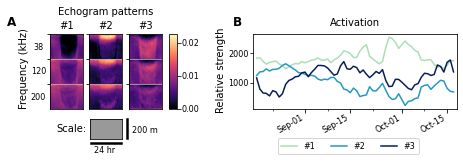

In [22]:
fig = plt.figure(figsize=(7+1/16,2.8))
gs_L = fig.add_gridspec(2,3, bottom=0.2, top=1.0, left=0.2,  right=0.42, hspace=0.15)
gs_R = fig.add_gridspec(2,1, bottom=0.2, top=1.0, left=0.6, right=1, hspace=0.15)

# Panel: daily echogram patterns
ax_pattern = plot_daily_echogram()

# Panel: Activation
ax_activation = plot_activation()

# Add echogram pattern labels
[ax_pattern[x-1].set_title('#%d' % x, fontsize=title_ls, pad=5) for x in np.arange(1,4,1)]

# Add component legend
ax_activation.legend(['#1', '#2', '#3'], 
                  fontsize=tick_ls,
                  bbox_to_anchor=(0.1, -0.65), 
                  loc='lower left', ncol=3)

# Add panel label
add_panel_A_label()
add_panel_B_label()

# Add frequency for echogram patterns
[fig.text(
        x=-0.35, y=yy, s=ss, transform=ax_pattern[0].transAxes,
        fontsize=freq_ls,
        ha='center', va='center')
    for ss,yy in zip(['200', '120', '38'], [0.15, 0.5, 0.825])]

# Add example axis for daily echogram patterns
plot_daily_echogram_pattern_scale()

# Save figure
fig.savefig(os.path.join('../figs/fig_results_decomp.png'),
            dpi=150, bbox_inches = 'tight', pad_inches = 0.05)
plt.show()